# Exercise 1: MD simulations of LJ-Ag

## SVOLGIMENTO PUNTO 4

---

## Consegna

### Parametri

In all simulations model Ag interatomic interactions using the LJ potential ($\varepsilon = 0.345$ eV and $\sigma = 2.644$ Å) with the cutoff radius at $R_C = 4.5$ Å. Assume $t_\text{th} = 3$ ps as thermalization time and use the simulation cell of 256-atoms (file `fcc100a256.txt` on the elearning page) unless stated differently. From point 3,

### Punto 1 ✅

Use a **sharp-cutoff** (no polynomial junction) approach and find the optimal timestep to perform a simulation from an initial temperature $T_\text{ini} = 50$ K. The optimal timestep is the maximum one such that $\frac{\delta E}{E} < 10^{−5}$. Consider the range 1, 25 fs and perform 5000 integration steps for each trial. Repeat the analysis for $T_\text{ini} = 500$ K and show that the criterion cannot be fulfilled however reducing the timestep.

#### Dall'analisi

Risulta un $dt$ ottimale di 20 fs per T=50

### Punto 2 ✅

Implement a **7-degree polynomial** junction for $R_P < r < R_C$ with $R_P = 4.2$ Å. Use the coefficients $A, B, \dots, H$ for the 0th, 1st, ..., 7th degree term respectively, as provided in the file `poly7.py` on the elearning page. Adapt the definition of forces accordingly. Check that for $T_\text{ini} = 50$ K the simulation is consistent with the sharp-cutoff one and find the optimal timestep for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K.

#### Dall'analisi

La simulazione con giunzione polinomiale a T=50 è consistente a quella con shar-cutoff. La cosa interessante è che a 500K, usando la giunzione polinomiale, si riesce a scendere sotto il valore di tolleranza di $\frac{\delta E}{E} < 10^{−5}$

Risultano $dt$ ottimali di 20, 6, 4, 3 fs rispettivamente per T = 50, 500, 1000, 5000

### Punto 3 ✅

For the following points, implement a steepest-descent procedure to start the simulation from a minimum energy configuration (use C= 0.005 Å/𝑒𝑉 and stop when the maximum force falls below 0.001 𝑒𝑉/Å).


Using the optimal timesteps found in point 2, perform 10 𝑝𝑠 long simulations for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K. Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result. Visualize the atomic trajectories of the atoms at the center of the
cluster and at the cube vertices for both the lowest and highest temperature and comment on
their difference.

---

## Svolgimento PUNTO 4

### 0) Importazioni e dati

In [1]:
import numpy as np
import sys
sys.path.append('../../') 
from libraries.CrystalStructure import CrystalStructure as Crystal
from libraries.CrystalDynamics import CrystalDynamics, CrystalDynamicsResult


In [2]:
# Nome del file (numero di atomi da studiare: 256)
filename = '../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a256_1.txt'

#### Dati globali

In [3]:
# boundaries della cella da studiare (crystal slab)
# pcb = [16.6416, 16.6416, np.inf]  # in Å
pcb = [16.6416, 16.6416, 166_416]  # in Å (z enorme (*10_000))

# temperature da studiare
temperatura = 1700 # in K, cerco una temperatura finale ~850 K

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# time step ottimale per 1700K
time_step = 3e-15 

# il numero di step è dato dal tempo totale (300ps) diviso il time step
tempo_totale = 300e-12
n_steps = int(tempo_totale / time_step)

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

In [4]:
# Inizializzo il cristallo dal file minimizzato con steepest-descent
cristallo = Crystal.from_file(filename)
# Setto il raggio di cutoff E la giunzione polinomiale
cristallo.set_R_C(4.5)
cristallo.set_R_P(4.2)
# Setto le condizioni al contorno periodiche (vanno settate DOPO R_C)
cristallo.set_pbc(pcb)

#### Aggiunta di un atomo in superficie al centro e a +2.4 Å dal massimo z

In [5]:
# prendo il massimo z di tutti gli atomi
massimo_z = np.max(cristallo.positions[:, 2])
# calcolo il centro del cristallo nelle direzioni x e y
centro_x, centro_y, _ = cristallo.crystal_center
# posiziono l'atomo ad una distanza di 2.4 Å sopra il massimo z
cristallo.add_atom([centro_x, centro_y, massimo_z + 2.4])

### 1) Simulazione di 300ps a T = 1700 K

In [6]:
from libraries.io import AtomTracker, XYZwriter
# Inizializzo il tracker per l'atomo aggiunto (ultimo atomo)
adatom_tracker = AtomTracker(index=-1, output_file='output/prove_tracker/adatom_track.txt')
# Inizializzo lo scrittore XYZ per salvare la dinamica
xyz_writer = XYZwriter(output_folder='output/prove_tracker/', dt=time_step, dump_interval=200)

Per 256 atomi, con scrittura dei file: 32 secondi

In [7]:
# Raccolgo le energie medie e le dev std
simulazione = CrystalDynamics(cristallo, 
                       atomic_mass=silver_mass, 
                       dt=time_step, 
                       temp_ini=temperatura, 
                       atom_tracker=adatom_tracker, 
                       xyz_writer= xyz_writer)  
simulazione.set_seed(12316543)

# stavolta output True per visualizzare con ovito
result: CrystalDynamicsResult = simulazione.run_dynamics(n_steps=n_steps, 
                                                        t_th=t_th,
                                                        output=False, 
                                                        n_print=100, 
                                                        track_last=False, 
                                                        debug=False)

⚠️ Vicini non calcolati in precedenza. Calcolo con R_C=4.5, R_P=4.2 e R_V=inf.


### 2) Analisi e plot

#### 2.1) Temperatura finale

In [8]:
print(f"{result.mean_temp} ± {result.std_temp} K")

860.3712124347954 ± 32.50451349214293 K


#### 2.2) Plot x,y di adatom

In [9]:
import matplotlib.pyplot as plt

# data = np.loadtxt("output/dynamics/steps100000~dt3e-15~T1700~Ag~257/adatom_track.txt", skiprows=1, delimiter="\t")
data = np.loadtxt("output/prove_tracker/adatom_track.txt", skiprows=2, delimiter="\t")
x = data[:, 1]
y = data[:, 2]

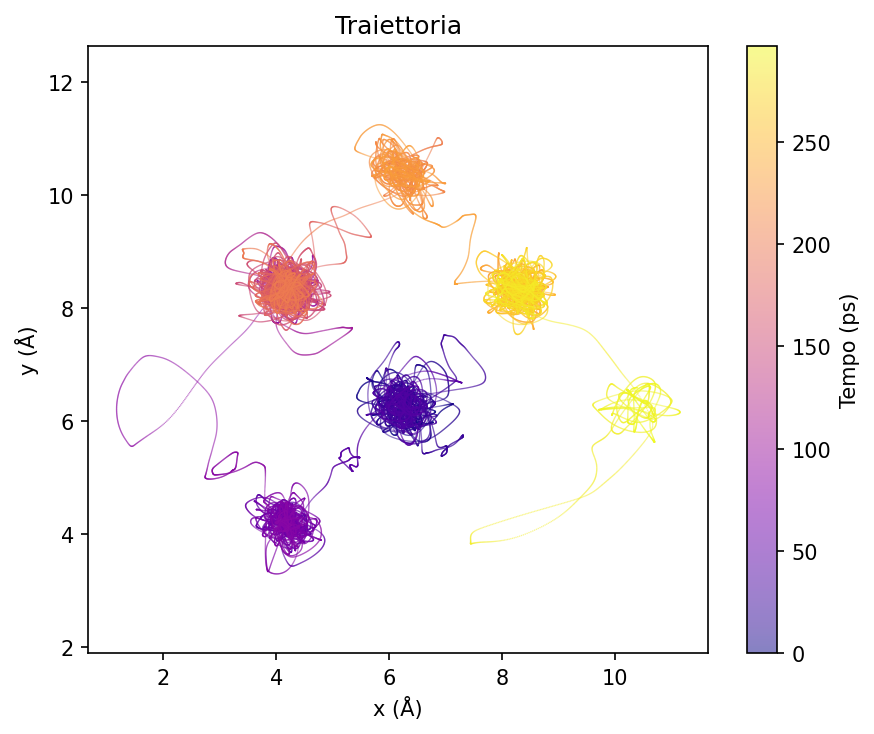

In [10]:
plt.figure(figsize=(6, 5), dpi=150)

# Creiamo un array di indici per il colore
time_indices = np.arange(len(x)) * (time_step * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter. 
# c=time_indices dice di usare l'indice per il colore
# s=0.5 rende i punti piccolissimi
# linewidth=0 toglie il bordo ai punti per evitare che si sovrappongano troppo
plt.scatter(x, y, c=time_indices, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.title("Traiettoria")
plt.axis('equal') # Per non distorcere la geometria

cbar = plt.colorbar()
cbar.set_label('Tempo (ps)')

plt.tight_layout()
plt.show()